# **<p style="text-align: center;"> Определение жанра по изображению обложки музыкального диска.</p>**

Оформление музыкального альбома как-то связано с его содержанием. Но насколько связано? Как подтвердить это, опираясь на данные? И чем это может быть полезно?

*Основная задача проекта:*

Необходимо разработать модель, которая определит жанр музыкального альбома по изображению его обложки.

In [5]:
import os
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pytesseract

from fastai.vision.all import *
from fastai.test_utils import *
from fastai.callback.all import *
from sklearn.metrics import confusion_matrix
from PIL import Image, ImageEnhance
from sklearn.feature_extraction.text import TfidfVectorizer

In [67]:
data = []
root_dir = 'data' 

for root, dirs, files in os.walk(root_dir):
    for file in files:
        if file.endswith('.png'): 
            path = os.path.join(root, file)
            label = os.path.basename(root)  # Название папки используется как метка жанра
            data.append((path, label))

genre_df = pd.DataFrame(data, columns=['filepath', 'label']) 

In [49]:
genre_df

,filepath,label
0,data/anime/830b2b4f-79cd-42c6-94f0-137bc2209ceb.png,anime
1,data/anime/a2187a6e-eaff-461d-82dc-311907959121.png,anime
2,data/anime/20fa8876-2afe-4487-9f07-f38778b99831.png,anime
3,data/anime/9f4c1d7b-7c35-4a18-b0fc-fb98b87d041b.png,anime
4,data/anime/682f02f8-8281-4f03-85f0-e0d320cf7eb5.png,anime
...,...,...
7795,data/pop/57826b15-44d5-49c3-8c23-5db6bd9c9dfc.png,pop
7796,data/pop/ebea5fe6-2cd1-4415-97d8-ce63e41052cf.png,pop
7797,data/pop/6feba009-221b-47e9-892a-588dc5ba2bd5.png,pop
7798,data/pop/35414336-a5b9-4e1d-a24c-97f282e804d1.png,pop


In [8]:
genre_counts = genre_df['label'].value_counts()
print(genre_counts)

label
country        1486
anime          1189
classical       955
jazz            821
pop             803
edm             719
reggae          581
disco           468
black metal     450
rap             328
Name: count, dtype: int64


Данные охватывают широкий спектр жанров, от "country" до "rap", что предполагает разнообразие визуальных стилей и элементов, связанных с каждым жанром. Количество изображений варьируется от 1486 в жанре "country" до 328 в жанре "rap". Такой разброс может привести к проблемам при обучении модели, так как модель может стать смещённой в сторону более часто встречающихся классов.

In [9]:
path = 'data'
dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=236, item_tfms=Resize(224))

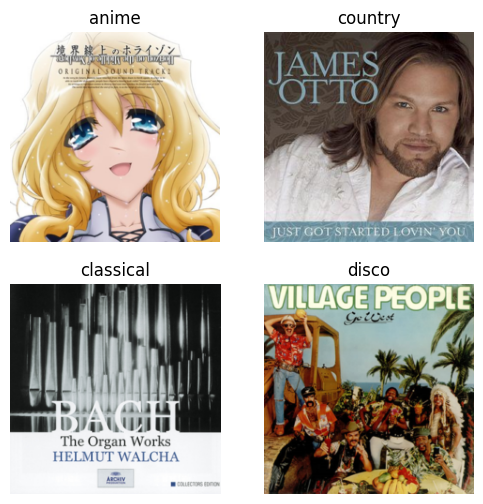

In [10]:
dls.show_batch(max_n=4)

In [11]:
print(f"Количество изображений в обучающем наборе: {len(dls.train_ds)}")
print(f"Количество изображений в валидационном наборе: {len(dls.valid_ds)}")

Количество изображений в обучающем наборе: 6240
Количество изображений в валидационном наборе: 1560


##  Обучение модели.

Для выполнения задачи классификации жанров музыкальных альбомов по изображениям обложек была использована предобученная сверточная нейронная сеть архитектуры ResNet34. Модель обучалась с использованием библиотеки FastAI, которая позволяет эффективно применять современные методы глубокого обучения.

Обучение модели проводилось методом fine_tune, который сначала адаптирует веса предобученной модели к новому набору данных, а затем уточняет весь набор параметров модели. Для обучения использовалась метрика точности (accuracy), которая позволяет оценить долю правильно классифицированных изображений. Обучение длилось 10 эпох с базовым уровнем скорости обучения 0.002.

In [12]:
# Создание модели
learn = vision_learner(
    dls, 
    resnet34, 
    metrics=accuracy,
    pretrained=True
)

# Обучение модели
learn.fine_tune(10, base_lr=0.002)

epoch,train_loss,valid_loss,accuracy,time
0,2.303693,1.477685,0.542949,00:06


epoch,train_loss,valid_loss,accuracy,time
0,1.431151,1.289148,0.581410,00:07
1,1.046300,1.326992,0.607051,00:07
2,0.659180,1.431090,0.604487,00:07
3,0.356008,1.535247,0.598718,00:07
4,0.188051,1.713850,0.612179,00:07
5,0.100966,1.688026,0.623718,00:07
6,0.056020,1.808357,0.611538,00:07
7,0.027742,1.738725,0.617949,00:07
8,0.017694,1.770367,0.619231,00:07
9,0.012360,1.738172,0.623077,00:07


Точность (accuracy) модели улучшается по мере обучения. Несмотря на улучшение точности, существует заметное увеличение потерь на валидационной выборке, начиная с третьей эпохи. Это является признаком переобучения, когда модель слишком точно адаптируется к тренировочной выборке и теряет способность обобщать на новых данных. 

In [13]:
learn = vision_learner(dls, resnet50, metrics=accuracy, pretrained=True)
learn.fine_tune(10, base_lr=0.001, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=3)])

epoch,train_loss,valid_loss,accuracy,time
0,2.127595,1.499133,0.566026,00:10


Better model found at epoch 0 with valid_loss value: 1.4991328716278076.


epoch,train_loss,valid_loss,accuracy,time
0,1.274918,1.292278,0.592949,00:12
1,0.945837,1.224125,0.621795,00:12
2,0.675959,1.242651,0.637179,00:12
3,0.429205,1.310678,0.639744,00:12
4,0.241903,1.362897,0.640385,00:12


Better model found at epoch 0 with valid_loss value: 1.2922776937484741.
Better model found at epoch 1 with valid_loss value: 1.2241250276565552.
No improvement since epoch 1: early stopping


Теперь я использовала архитектуру ResNet50, которая является более глубокой версией сети ResNet по сравнению с ResNet34 - это  улучшило способность модели к обучению за счёт более глубокого и сложного представления. 

In [14]:
learn.fit_one_cycle(10, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.570986,1.220935,0.622436,00:13
1,0.555676,1.226559,0.628846,00:12
2,0.480503,1.216401,0.637179,00:12
3,0.380590,1.234181,0.635256,00:12
4,0.336481,1.249184,0.632692,00:12
5,0.256208,1.240803,0.637179,00:12
6,0.237694,1.257168,0.639744,00:12
7,0.206038,1.264125,0.635897,00:12
8,0.207363,1.258171,0.642949,00:12
9,0.186679,1.271805,0.635897,00:12


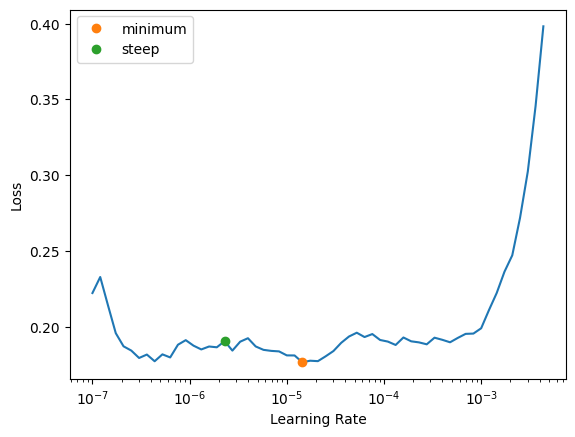

In [15]:
lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

На графике изображена зависимость потерь от скорости обучения (learning rate) во время поиска оптимального значения скорости обучения для модели. Ось Y отображает значение потерь (loss), а ось X — логарифмическую шкалу скоростей обучения. График помогает определить, при каком значении скорости обучения модель эффективно учится, не переобучаясь.

- зелёная точка ("steep")- это точка с самым крутым спадом потерь. Использование скорости обучения, близкой к этой точке, предполагает, что модель быстро снижает потери, что может быть оптимальным для эффективного обучения.

- оранжевая точка ("minimum") - это точка с наименьшими потерями до того, как начинается резкое увеличение потерь. Использование скорости обучения около этой точки также может быть эффективным, хотя есть риск начала переобучения или нестабильности в обучении, если скорость будет слишком высока.

Я планирую обучить модель на 10 эпохах, используя циклическую политику скорости обучения, где скорость будет изменяться в пределах от 1e-6 до 1e-4. Это диапазон включает значения вблизи обеих отмеченных точек, что позволит изучить, как модель реагирует на разные скорости обучения в этом интервале.

Результаты (lr_min и lr_steep) предоставляют рекомендуемые значения скорости обучения, основанные на минимальных потерях и самом крутом спаде потерь.Можно выбрать значение скорости обучения около "steep" для быстрого улучшения или около "minimum" для потенциально лучших, но возможно более рискованных результатов.

In [16]:
dls_1 = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=237,
                                   item_tfms=Resize(224),
                                   batch_tfms=aug_transforms(mult=2, max_zoom=2.0, max_warp=0.2))
learn_1 = vision_learner(dls_1, resnet101, metrics=accuracy, pretrained=True, wd=0.1)

In [17]:
learn_1.fit_one_cycle(
    10, 
    lr_max=3e-4,
    cbs=[
        SaveModelCallback(monitor='valid_loss', fname='best_model'),  
        EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=3) 
    ]
)

epoch,train_loss,valid_loss,accuracy,time
0,3.075181,1.822763,0.417949,00:16
1,2.312705,1.351830,0.558333,00:15
2,1.938959,1.249291,0.608974,00:16
3,1.754822,1.184188,0.614103,00:16
4,1.592099,1.146918,0.625641,00:15
5,1.432325,1.115826,0.632051,00:15
6,1.394564,1.083208,0.648077,00:15
7,1.337842,1.065848,0.645513,00:15
8,1.290274,1.053469,0.655128,00:15
9,1.300617,1.053439,0.655769,00:15


Better model found at epoch 0 with valid_loss value: 1.8227628469467163.
Better model found at epoch 1 with valid_loss value: 1.3518297672271729.
Better model found at epoch 2 with valid_loss value: 1.2492907047271729.
Better model found at epoch 3 with valid_loss value: 1.1841882467269897.
Better model found at epoch 4 with valid_loss value: 1.1469182968139648.
Better model found at epoch 5 with valid_loss value: 1.1158262491226196.
Better model found at epoch 6 with valid_loss value: 1.0832083225250244.
Better model found at epoch 7 with valid_loss value: 1.065847635269165.
Better model found at epoch 8 with valid_loss value: 1.0534685850143433.
Better model found at epoch 9 with valid_loss value: 1.0534385442733765.


Далее я применила увеличенный набор аугментаций к изображениям, включая увеличение масштаба в два раза и искажения, чтобы увеличить разнообразие тренировочных данных и улучшить способность модели к обобщению. Создала модель на базе архитектуры resnet101, которая более глубокая и мощная по сравнению с ResNet34 и ResNet50, используемыми ранее - это привело к лучшей точности за счет более глубокого изучения признаков. Так же здесь я использовала циклический подход к изменению скорости обучения, начиная с медленной, увеличивая и снова снижая в течение обучения.

In [18]:
learn_1.fine_tune(15, base_lr=0.001, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=3)])

epoch,train_loss,valid_loss,accuracy,time
0,1.368928,1.152268,0.623077,00:15


Better model found at epoch 0 with valid_loss value: 1.1522678136825562.


epoch,train_loss,valid_loss,accuracy,time
0,1.285661,1.067323,0.652564,00:20
1,1.202118,1.013894,0.669231,00:20
2,1.136139,1.024148,0.667308,00:20
3,1.082096,0.969730,0.689103,00:20
4,0.974940,0.958538,0.683974,00:20
5,0.922058,0.965866,0.683974,00:20
6,0.812128,0.928798,0.705128,00:20
7,0.731382,0.912898,0.702564,00:20
8,0.668771,0.915110,0.709615,00:20
9,0.597810,0.917481,0.713462,00:20


Better model found at epoch 0 with valid_loss value: 1.067323088645935.
Better model found at epoch 1 with valid_loss value: 1.013893723487854.
Better model found at epoch 3 with valid_loss value: 0.9697297811508179.
Better model found at epoch 4 with valid_loss value: 0.9585380554199219.
Better model found at epoch 6 with valid_loss value: 0.928797721862793.
Better model found at epoch 7 with valid_loss value: 0.9128980040550232.
Better model found at epoch 10 with valid_loss value: 0.8976699709892273.
No improvement since epoch 10: early stopping


Точность на валидационной выборке (accuracy) увеличилась и достигла  71.41, что является хорошим показателем. Модель демонстрирует стабильное улучшение как в тренировочной, так и валидационной точности, что говорит о правильно подобранных параметрах и эффективности выбранной архитектуры сети и процесса обучения

In [19]:
dls_152 = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=237,
                                   item_tfms=Resize(224),
                                   batch_tfms=aug_transforms(mult=2, max_zoom=2.0, max_warp=0.2))
learn_152 = vision_learner(dls_152, resnet152, metrics=accuracy, pretrained=True, wd=0.1)

In [20]:
learn_152.fit_one_cycle(
    10, 
    lr_max=3e-4,
    cbs=[
        SaveModelCallback(monitor='valid_loss', fname='best_model_152'),  
        EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=3) 
    ]
)

epoch,train_loss,valid_loss,accuracy,time
0,3.082498,1.767595,0.421795,00:21
1,2.373904,1.351546,0.568590,00:20
2,1.949397,1.231605,0.595513,00:21
3,1.738911,1.174080,0.619231,00:21
4,1.564379,1.119517,0.624359,00:21
5,1.448645,1.097115,0.638462,00:21
6,1.339820,1.054869,0.651923,00:21
7,1.310198,1.047076,0.657051,00:21
8,1.268054,1.045535,0.651282,00:20
9,1.276228,1.032385,0.658974,00:21


Better model found at epoch 0 with valid_loss value: 1.7675951719284058.
Better model found at epoch 1 with valid_loss value: 1.3515464067459106.
Better model found at epoch 2 with valid_loss value: 1.2316054105758667.
Better model found at epoch 3 with valid_loss value: 1.1740800142288208.
Better model found at epoch 4 with valid_loss value: 1.1195173263549805.
Better model found at epoch 5 with valid_loss value: 1.0971150398254395.
Better model found at epoch 6 with valid_loss value: 1.0548694133758545.
Better model found at epoch 7 with valid_loss value: 1.0470763444900513.
Better model found at epoch 8 with valid_loss value: 1.0455348491668701.
Better model found at epoch 9 with valid_loss value: 1.0323853492736816.


In [21]:
learn_152.fine_tune(15, base_lr=0.001, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)])

epoch,train_loss,valid_loss,accuracy,time
0,1.383763,1.124895,0.626923,00:21


Better model found at epoch 0 with valid_loss value: 1.1248949766159058.


epoch,train_loss,valid_loss,accuracy,time
0,1.233872,1.025388,0.656410,00:27
1,1.141332,1.003247,0.659615,00:27
2,1.072454,0.969756,0.675641,00:27
3,1.011457,0.942977,0.691667,00:27
4,0.933059,0.936574,0.691026,00:27
5,0.848180,0.927235,0.697436,00:27
6,0.750381,0.908464,0.711538,00:27
7,0.676842,0.909145,0.709615,00:27
8,0.599737,0.884640,0.725000,00:27
9,0.555488,0.902238,0.721795,00:27


Better model found at epoch 0 with valid_loss value: 1.0253875255584717.
Better model found at epoch 1 with valid_loss value: 1.0032474994659424.
Better model found at epoch 2 with valid_loss value: 0.9697558283805847.
Better model found at epoch 3 with valid_loss value: 0.9429771304130554.
Better model found at epoch 4 with valid_loss value: 0.9365738034248352.
Better model found at epoch 5 with valid_loss value: 0.9272351264953613.
Better model found at epoch 6 with valid_loss value: 0.9084644317626953.
Better model found at epoch 8 with valid_loss value: 0.8846400380134583.
No improvement since epoch 8: early stopping


In [22]:
dls_r152 = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=237,
                                       item_tfms=Resize(224))

learn_r152 = vision_learner(dls_r152, resnet152, metrics=accuracy, pretrained=True, wd=0.1)

learn_r152.fine_tune(15, base_lr=0.001, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)])

epoch,train_loss,valid_loss,accuracy,time
0,2.206635,1.477414,0.569231,00:20


Better model found at epoch 0 with valid_loss value: 1.4774138927459717.


epoch,train_loss,valid_loss,accuracy,time
0,1.312640,1.206286,0.619231,00:27
1,0.989173,1.144319,0.637821,00:27
2,0.716999,1.161508,0.646154,00:26
3,0.448516,1.145704,0.660256,00:26
4,0.264948,1.238395,0.664103,00:26
5,0.163084,1.299288,0.659615,00:26
6,0.103699,1.301133,0.669231,00:26


Better model found at epoch 0 with valid_loss value: 1.2062857151031494.
Better model found at epoch 1 with valid_loss value: 1.1443192958831787.
No improvement since epoch 1: early stopping


Обучение модели без применения аугментации показывает результаты хуже.
Создала модель на базе архитектуры resnet152, которая более глубокая и мощная по сравнению с ResNet34,ResNet50 и ResNet101, используемыми ранее - это привело к лучшей точности за счет более глубокого изучения признаков.

**<p style="text-align: center;"> Могу сделать вывод:</p>**

Модель ResNet152 в качестве основы продемонстрировала способность эффективно классифицировать жанры музыкальных альбомов на основе их обложек, что может быть полезно для автоматизации музыкальной библиотеки или рекомендательных систем. Обучение показало постепенное улучшение точности, что свидетельствует о правильности выбранной стратегии обучения и настройки модели.


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

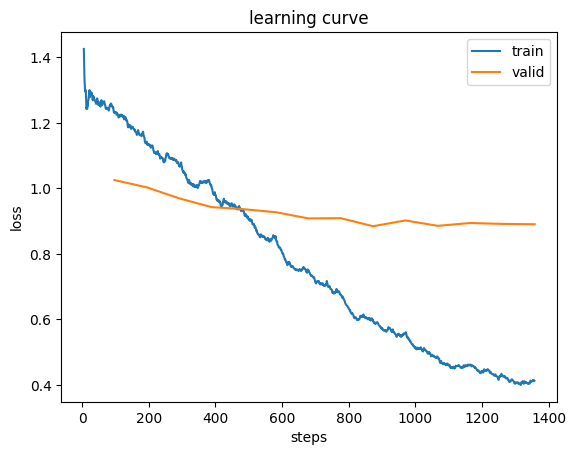

In [23]:
learn_152.recorder.plot_loss()

Снижение тренировочных потерь достаточно стабильно и продолжительно, что указывает на эффективное обучение модели. К концу обучения потери продолжают снижаться, что может быть признаком недостаточной сложности модели по отношению к данным, либо недообучения.
Потери на валидационном наборе данных не снижаются и даже имеют некоторый рост. Это может указывать на переобучение модели: она хорошо работает на тренировочных данных, но не может так же хорошо обобщать на новых данных.

In [24]:
# Получение предсказаний и истинных значений для валидационного набора данных
# preds - тензор вероятностей предсказаний модели для каждого класса
# targs - тензор истинных меток классов

preds, targs = learn.get_preds()

In [25]:
# Получение максимальных вероятностей и предсказанных классов
max_preds = np.argmax(preds, axis=1) # получаем индексы классов с максимальной вероятностью

# Сравнение предсказанных классов с истинными
mistakes = max_preds != targs
mistake_indices = np.where(mistakes)[0] # индексы ошибочных предсказаний

# Анализ примеров, где были допущены ошибки
for idx in mistake_indices[:10]: # показать первые 10 ошибок
    print(f"Index: {idx}, Predicted: {max_preds[idx]}, Actual: {targs[idx]}")


Index: 1, Predicted: 6, Actual: 5
Index: 3, Predicted: 5, Actual: 7
Index: 8, Predicted: 0, Actual: 6
Index: 11, Predicted: 8, Actual: 9
Index: 14, Predicted: 9, Actual: 4
Index: 15, Predicted: 6, Actual: 4
Index: 21, Predicted: 4, Actual: 2
Index: 22, Predicted: 4, Actual: 7
Index: 23, Predicted: 3, Actual: 4
Index: 24, Predicted: 5, Actual: 6


In [26]:
max_preds, indices = torch.max(preds, dim=1)  # Наибольшие предсказанные вероятности и их индексы
true_probs = preds[range(len(preds)), targs]  # Вероятности истинных классов

# Вычисление ошибок как разниц между наибольшей предсказанной вероятностью и вероятностью истинного класса
errors = max_preds - true_probs

In [27]:
# Получение индексов отсортированных по убыванию ошибок
error_indices = torch.argsort(errors, descending=True)

# Вывод информации о примерах с наибольшими ошибками
for idx in error_indices[:5]:  # Показать первые 5 примеров с наибольшими ошибками
    print(f"Index: {idx}, Predicted: {indices[idx]}, True: {targs[idx]}, Error: {errors[idx]}")

Index: 714, Predicted: 3, True: 9, Error: 0.9994845986366272
Index: 450, Predicted: 6, True: 8, Error: 0.9992184638977051
Index: 417, Predicted: 0, True: 5, Error: 0.9941151142120361
Index: 949, Predicted: 4, True: 7, Error: 0.9940211176872253
Index: 1233, Predicted: 0, True: 9, Error: 0.9938822984695435


Predicted: country (Prob: 0.9995), Actual: reggae (Prob: 0.0000)
Predicted: jazz (Prob: 0.9992), Actual: rap (Prob: 0.0000)
Predicted: anime (Prob: 0.9960), Actual: edm (Prob: 0.0019)
Predicted: disco (Prob: 0.9966), Actual: pop (Prob: 0.0026)
Predicted: anime (Prob: 0.9950), Actual: reggae (Prob: 0.0011)


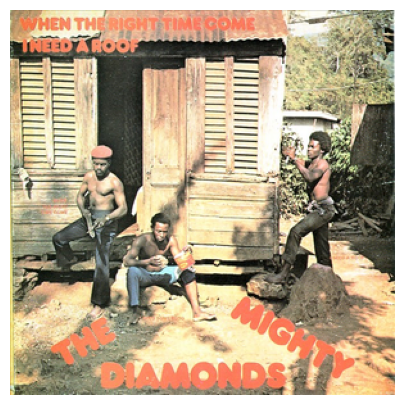

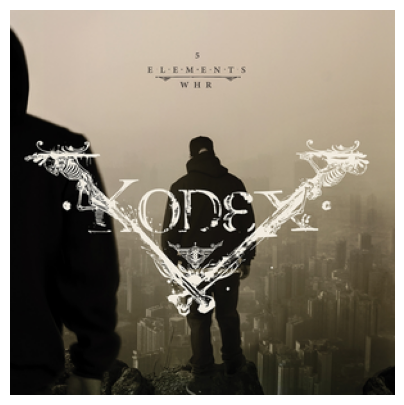

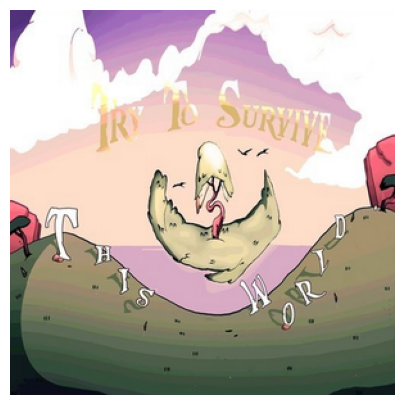

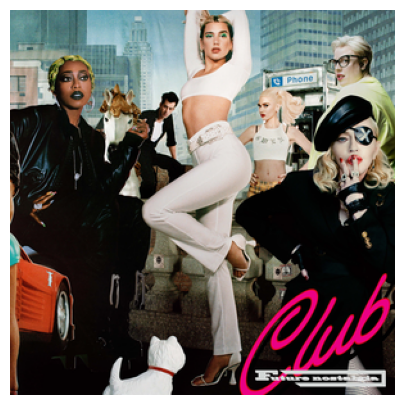

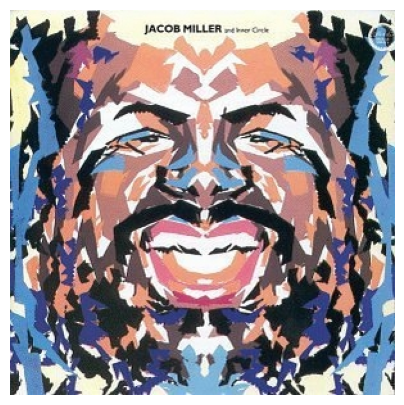

In [28]:
# Визуализация примеров с наибольшими ошибками
for idx in error_indices[:5]:  
    img, _ = dls.valid_ds[idx]
    img.show()
    print(f"Predicted: {dls.vocab[indices[idx]]} (Prob: {max_preds[idx]:.4f}), Actual: {dls.vocab[targs[idx]]} (Prob: {true_probs[idx]:.4f})")

Дальше можно пойти по пути: для улучшения метрики удалить или объединить музыкальные жанры. 

Однако, я решила сосредоточиться на анализе ошибок модели, поскольку для истинных меломанов точное разделение музыкальных жанров имеет большое значение.

После визуализации примеров с наибольшими ошибками, модель продемонстрировала способность улавливать нюансы различных музыкальных направлений и показала очень хорошие результаты. Однако остаются аспекты, которые требуют дополнительного внимания, в частности, улучшение распознавания текста на обложках и идентификация конкретных знаменитостей.

**Рекомендация:** 

- Для улучшения распознавания начинающих исполнителей рекомендуется создавать обложки альбомов, чётко отображающие ключевые особенности жанра. Это облегчит покупателям задачу идентификации уникальных черт музыки новых артистов и их стилей.

Исследование ошибок модели показало, что значительное количество ошибок происходит на обложках, где присутствует изображение человека. Ошибки могут быть связаны с тем, что на этих обложках присутствуют ключевые визуальные элементы, такие как текст и лица известных личностей, которые модель не учитывает.

In [29]:
# чтобы увидеть, какие жанры больше всего путаются, загружу данные о них в DataFrame
# Создание списка для хранения данных
errors_data = []

# Заполнение списка данными об ошибках
for idx in error_indices:
    predicted_label = dls.vocab[indices[idx]]
    actual_label = dls.vocab[targs[idx]]
    predicted_prob = max_preds[idx].item()
    actual_prob = true_probs[idx].item()
    errors_data.append({
        'индекс': idx,
        'предсказанный жанр': predicted_label,
        'фактический жанр': actual_label,
        'вероятность предсказанного': predicted_prob,
        'вероятность фактического': actual_prob
    })

# Создание DataFrame из списка
errors_df = pd.DataFrame(errors_data)

In [30]:
errors_df

,индекс,предсказанный жанр,фактический жанр,вероятность предсказанного,вероятность фактического
0,tensor(714),country,reggae,0.999508,0.000023
1,tensor(450),jazz,rap,0.999233,0.000014
2,tensor(417),anime,edm,0.995992,0.001876
3,tensor(949),disco,pop,0.996631,0.002610
4,tensor(1233),anime,reggae,0.994954,0.001071
...,...,...,...,...,...
1555,tensor(647),jazz,jazz,0.864541,0.864541
1556,tensor(645),black metal,black metal,0.997162,0.997162
1557,tensor(644),classical,classical,0.908425,0.908425
1558,tensor(641),edm,edm,0.999971,0.999971


In [31]:
errors = errors_df[errors_df['предсказанный жанр'] != errors_df['фактический жанр']]

errors

,индекс,предсказанный жанр,фактический жанр,вероятность предсказанного,вероятность фактического
0,tensor(714),country,reggae,0.999508,0.000023
1,tensor(450),jazz,rap,0.999233,0.000014
2,tensor(417),anime,edm,0.995992,0.001876
3,tensor(949),disco,pop,0.996631,0.002610
4,tensor(1233),anime,reggae,0.994954,0.001071
...,...,...,...,...,...
563,tensor(500),country,reggae,0.401049,0.391009
564,tensor(532),jazz,disco,0.369163,0.359763
565,tensor(1143),anime,pop,0.490032,0.483119
566,tensor(717),anime,pop,0.441864,0.435296


In [32]:
# Создание pivot table для анализа ошибок классификации
error_pivot = errors.pivot_table(index='фактический жанр', columns='предсказанный жанр', aggfunc='size', fill_value=0)

# Вывод сводной таблицы
error_pivot

предсказанный жанр,anime,black metal,classical,country,disco,edm,jazz,pop,rap,reggae
фактический жанр,,,,,,,,,,
anime,0,1,3,10,0,10,1,13,1,3
black metal,4,0,0,0,2,3,1,0,1,0
classical,3,1,0,9,4,4,8,4,2,0
country,9,3,9,0,9,4,17,21,8,12
disco,11,2,0,12,0,8,11,10,1,6
edm,12,5,4,9,5,0,7,12,2,4
jazz,6,4,11,22,7,7,0,13,6,13
pop,27,1,1,24,8,15,8,0,6,1
rap,2,2,0,7,0,1,4,7,0,4


Проанализировав сводную таблицу ошибок по жанрам и изначального распределения жанров в наборе данных, можно сделать вывод:

- Anime и Pop - модель чаще всего путает эти жанры с другими. Например, аниме часто путают с pop, country и EDM 

- Country - это жанр, который модель наиболее трудно классифицирует, чаще всего путая его с джазом и поп-музыкой 
 
- Classical, Disco, EDM, Jazz - эти жанры также испытывают высокую степень путаницы с другими жанрами. Например, классическая музыка часто путается с кантри и джазом, диско с кантри и EDM, а EDM — с поп-музыкой и кантри

- Jazz - показывает высокую степень путаницы со многими жанрами, особенно с кантри 

- Rap и Reggae - модель лучше справляется с этими жанрами, но всё же допускает ошибки, например, путая рэп с кантри и поп-музыкой, а регги с кантри и поп-музыкой.

Модели сложно различать жанры с высокой степенью схожести визуальных образов обложек. Особенно сложности возникают там, где визуальные стереотипы жанров перекрываются или нечетко выражены. 

In [33]:
# Ваши метки должны быть в формате списка или массива
y_true = errors_df['фактический жанр'].tolist()
y_pred = errors_df['предсказанный жанр'].tolist()

# Создание матрицы ошибок
cm = confusion_matrix(y_true, y_pred)

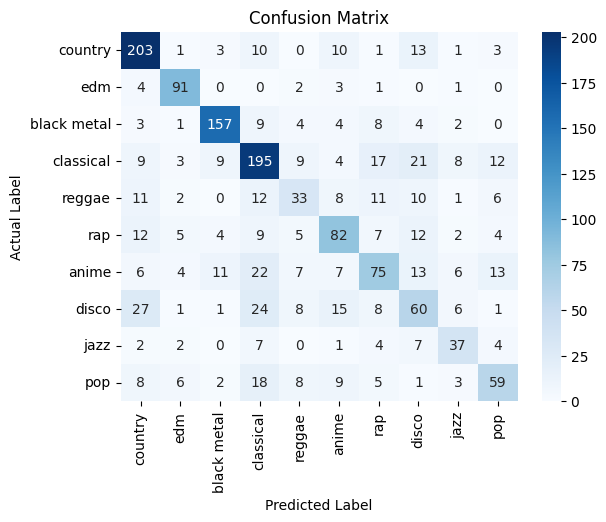

In [34]:
# Построение тепловой карты
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=set(y_pred), yticklabels=set(y_true))
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

На основе матрицы ошибок (confusion matrix) можно сделать следующий вывод:

- Country сильно выделяется с 203 правильными классификациями. Модель хорошо распознаёт этот жанр, несмотря на некоторую путаницу с EDM и поп-музыкой.
    
- Classical также демонстрирует хорошие результаты с 195 правильными ответами, хотя и с путаницей с кантри и джазом.

- Black Metal и EDM показывают умеренные результаты с 157 и 91 правильными классификациями соответственно. Оба жанра иногда путают с другими, особенно black metal с классической музыкой и EDM с диско.
    
- Anime и Rap имеют схожие показатели с 75 и 82 правильными классификациями, но часто путаются с другими жанрами.

- Disco, Jazz, Pop и Reggae показывают невысокую точность классификации, особенно disco, который часто путают с country и EDM, что указывает на возможное схожество визуальных стилей обложек.

Многие жанры часто путаются с кантри, попом и EDM, что может указывать на схожесть визуальных мотивов или недостаточное количество тренировочных данных для этих категорий. Визуальное сходство между обложками разных жанров вызывает затруднения для модели, особенно в случае менее чётко определённых жанровых границ.

Рекомендация:

- нужно расширить модель за счет интеграции текстовых данных, чтобы повысить точность распознавания музыкальных жанров, особенно когда обложки альбомов содержат текст, который может дать дополнительные подсказки о жанре. Текст с обложек альбомов может включать названия песен, имена артистов и другие данные, которые могут быть важны для классификации. 

**<p style="text-align: center;"> Итоговый вывод:</p>**

В ходе выполнения проекта была разработана модель для классификации музыкальных жанров на основе обложек альбомов. Обученная модель, использующая архитектуру ResNet152 и аугментированные данные, продемонстрировала хороший результат с точностью классификации 73.27%. Однако, анализ матрицы ошибок позволил выявить несколько ключевых аспектов.

Модель успешно распознала некоторые жанры, такие как Country и Classical, с высокой точностью. Однако, существует путаница между некоторыми жанрами, особенно с EDM и Pop. Это может быть связано как с визуальным сходством обложек, так и с неоднозначностью самих жанров.

Для улучшения точности классификации рекомендуется внедрить текстовые данные, содержащиеся на обложках альбомов. Это может включать названия песен, имена артистов и другие данные, которые могут дополнить визуальную информацию и улучшить классификацию.

Чтобы сократить схожесть между обложками разных жанров, можно рассмотреть возможность разработки уникальных визуальных стилей для каждого жанра. Это поможет модели лучше различать обложки и повысит точность классификации.

В целом модель успешно справилась с поставленной задачей классификации музыкальных жанров на основе внешнего вида обложек альбомов. Это подтверждается высокими показателями точности классификации, достигнутыми без использования текста или информации о знаменитостях. Это говорит о том, что модель эффективно улавливает конкретные символы и визуальные элементы, характерные для каждого жанра, что позволяет ей точно классифицировать музыкальные направления. Такой подход открывает новые перспективы для разработки и применения алгоритмов машинного обучения в области музыкальной индустрии, позволяя автоматизировать процессы распознавания и классификации музыкальных жанров на основе обложек альбомов.
